In [43]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel

add_data_manually = True  # to add latest info not in the database yet
countries = ['New Zealand','Italy']

DataSource = 'OurWorldData'

if DataSource == 'JohnHopkins':
    fname = 'time_series_19-covid-Confirmed.csv'

    if os.path.exists(fname):
        os.remove(fname)

    ddir = 'data/'
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    ff = wget.download(url)
    print (ff)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

    dd = pd.read_csv(ff)

else:
    fname = 'full_data.csv'
    if os.path.exists(fname):
        os.remove(fname)
    
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    ff = wget.download(url)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'
    dd = pd.read_csv(ff, parse_dates = ['date'])
    
    
## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



In [44]:
dd['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Curacao', 'Cyprus', 'Czech Republic',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia', 'Georgia', 'Ger

In [45]:
dd

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
7600,2020-03-25,Zimbabwe,0,0,2,1
7601,2020-03-26,Zimbabwe,1,0,3,1
7602,2020-03-27,Zimbabwe,0,0,3,1
7603,2020-03-28,Zimbabwe,2,0,5,1


           date     location  new_cases  new_deaths  total_cases  total_deaths
4988 2019-12-31  New Zealand          0           0            0             0
4989 2020-01-01  New Zealand          0           0            0             0
4990 2020-01-02  New Zealand          0           0            0             0
4991 2020-01-03  New Zealand          0           0            0             0
4992 2020-01-04  New Zealand          0           0            0             0
...         ...          ...        ...         ...          ...           ...
5064 2020-03-25  New Zealand         47           0          189             0
5065 2020-03-26  New Zealand         73           0          262             0
5066 2020-03-27  New Zealand         76           0          338             0
5067 2020-03-28  New Zealand         78           0          416             0
5068 2020-03-29  New Zealand         60           1          476             1

[81 rows x 6 columns]
2020-03-02 00:00:00 62
New Ze

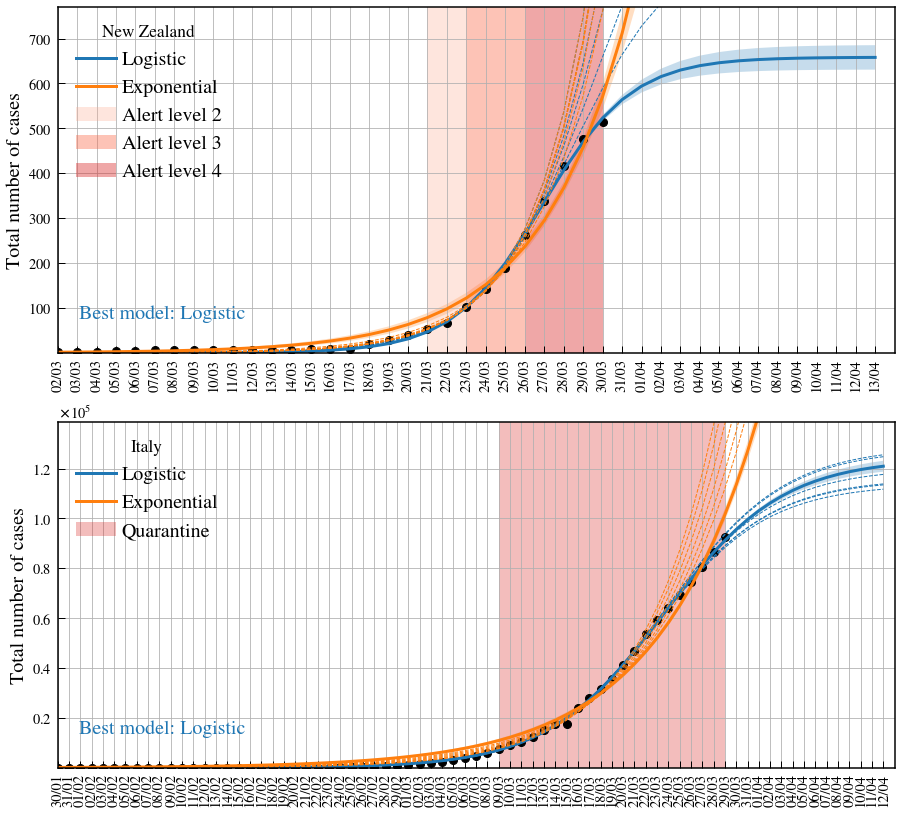

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'), 
        'Exponential': ExponentialModel() }#,
        #'3rd deg. Polynomial': PolynomialModel(degree=3)}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,ncountries*7))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

countryvar = 'location' if DataSource == 'OurWorldData' else 'Country/Region'

covid_dict = {}

for icc,country in enumerate(countries):

    sel = dd[countryvar] == country
    dc = dd.loc[sel]
    print (dc)
    cols = list(dc.columns)
    dates = cols[4:] if DataSource == 'JohnHopkins' else dc['date'].reset_index(drop=True)

    if DataSource == 'JohnHopkins':
        nn = []
        for i in dates:
            nn.append(dc[i].to_numpy()[0])
    else:
        nn      = dc['total_cases'].reset_index(drop=True).to_numpy()
        ndeaths = dc['total_deaths'].reset_index(drop=True).to_numpy()
        nnew    = dc['new_cases'].reset_index(drop=True).to_numpy()
        
    xstart = 0
    
    for ii, inn in enumerate(list(nn)):
        if inn > 1:
            xstart = ii-1 if ii > 1 else 0
            break
#    import pdb ; pdb.set_trace()        
    nn = nn[xstart:]
    if DataSource != 'JohnHopkins':
        ndeaths  = ndeaths[xstart:]
        nnew     = nnew[xstart:]
        
    print (dates.iloc[xstart], xstart)
    dates = dates.iloc[xstart:].reset_index(drop=True)
    
    # ensuring data completeness    
    dates_all = pd.date_range(start=dates.iloc[0], end=dates.iloc[-1])
    ntotal      = [] #np.zeros(len(dates_all))
    ntot_deaths = []
    ntot_new    = []
    
    
    iid = 0
    for ixx, idate in enumerate(dates_all):
        if dates.iloc[iid] == idate:
            ntotal.append(nn[iid])
            ntot_deaths.append(ndeaths[iid])
            ntot_new.append(nnew[iid])
            iid += 1
        else:
            ntotal.append(ntotal[ixx-1])
            ntot_deaths.append(ntot_deaths[ixx-1])
            ntot_new.append(ntot_new[ixx-1])
            
    
    #import pdb ; pdb.set_trace()
    
    if add_data_manually:
        if country == 'Chile':
            ntotal.append(2139)
            ntot_deaths.append(ntot_deaths[-1])
            ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
        if country == 'New Zealand':
            ntotal.append(514)
            ntot_deaths.append(0)
            ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
    
    nn = ntotal
    dates = dates_all
    xstart = 0
    
    covid_dict[country] = {'dates': dates,
                         'ntotal': ntotal,
                         'ntot_deaths': ntot_deaths,
                          'ntot_new':ntot_new
                         }
    
    print (country, xstart)
    ndata = len(nn)
    nn = np.array(nn)
    xx = np.arange(0,ndata)
    xxx = np.arange(0,ndata+14)
    nper = len(xxx)
    print (country, nper)
    xxxx = np.arange(0,ndata+14)# if nper < 100 else 2)
    datesxxx = pd.date_range(start=dates[0], periods=nper).strftime('%d/%m')
    
    #import pdb ; pdb.set_trace()    
    
    print (datesxxx)
    
    if ncountries > 1:
        ax = axs[icc]
    else:
        ax = axs

    
    ax.set_xticks(xxxx)
    ax.set_xticklabels(datesxxx[xxxx], rotation='vertical')
    ax.plot(xx,nn,'ko',markersize=8)
    #ax.set_yscale('log')

    icol = 0 
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > 8)[0]
    bics = []
    mn = []
    
    for mname, model in models.items():
       
        pars0 = model.guess(nn[ixx], x=xx[ixx])
        out = model.fit(nn[ixx], pars0, x=xx[ixx])
        pars = out.params
        bics.append(out.bic)
        mn.append(mname)
 
        dely = out.eval_uncertainty(x=xxx)
        y =  out.eval(pars,x=xxx)        
        ax.plot(xxx,y, '-', label=f'{mname}', color=colors[icol],linewidth=3)
        ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
        
        
        if mname == 'Exponential' or mname == 'Logistic':
            for prev_fit in [-2,-3,-4,-5,-6,-7]:
                print (prev_fit)
                pars0 = model.guess(nn[ixx[:prev_fit]], x=xx[ixx[:prev_fit]])
                out = model.fit(nn[ixx[:prev_fit]], pars0, x=xx[ixx[:prev_fit]])
                pars = out.params
                #bics.append(out.bic)
                #mn.append(mname)

                #dely = out.eval_uncertainty(x=xxx)
                y =  out.eval(pars,x=xxx)        
                ax.plot(xxx,y, '--', color=colors[icol],linewidth=1)
                #ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
                #icol += 1
        
        icol += 1
        
        
        
       # print (mname, country, y[len(xx) + 11], bics[-1])
    
    bic = np.argmin(bics)
    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
           transform=ax.transAxes, color= colors[bic])


    ax.set_xlim([0,ndata + 14])
    ax.set_ylim([0.1,np.min([200000, np.max(nn)*1.5])])
    ax.ticklabel_format(axis='y', style='sci',useMathText=True, scilimits=(0,5))
    ax.set_ylabel('Total number of cases',fontsize=20)
    
    ax.grid()
    

    if country == 'New Zealand':
        
        alert_colors = plt.cm.Reds(np.linspace(0.3,0.7, 3))
        alert_dates = ['21/03','23/03','26/03']
        ix_alert = []
        for alert in alert_dates:
            sel = np.where(alert == datesxxx)[0]
            print (sel)
            ix_alert.append(sel[0])
        
        ax.fill_between([ix_alert[0], ix_alert[1]], [0,0],[1e4,1e4], facecolor=alert_colors[0],alpha=0.3,label='Alert level 2')
        ax.fill_between([ix_alert[1], ix_alert[2]], [0,0],[1e4,1e4], facecolor=alert_colors[1],alpha=0.4,label='Alert level 3')
        ax.fill_between([ix_alert[2], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.4,label='Alert level 4')
    
    if country == 'Italy':
        alert_colors = plt.cm.Reds(np.linspace(0.3,0.7, 3))
        alert_dates = ['09/03']#,'23/03','26/03']
        ix_alert = []
        for alert in alert_dates:
            sel = np.where(alert == datesxxx)[0]
            print (sel)
            ix_alert.append(sel[0])
        
        ax.fill_between([ix_alert[0], xx[-1]], [0,0],[1e6,1e6], facecolor=alert_colors[-1],alpha=0.3,label='Quarantine')
      #  ax.fill_between([ix_alert[1], ix_alert[2]], [0,0],[1e4,1e4], facecolor=alert_colors[1],alpha=0.4,label='Alert level 3')
      #  ax.fill_between([ix_alert[2], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.4,label='Alert level 4')

    
    ax.legend(title=country, fontsize=20,loc='upper left')
plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)

In [47]:

print (covid_dict['New Zealand']['dates'].min())


2020-03-02 00:00:00


In [48]:
def figures_to_html(figs, filename="test2.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head><style>div {display: inline-block;}</style></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html(auto_play=False).split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")

In [49]:
import plotly.graph_objects as go

animated_plot = True
allfigs = []

if animated_plot:

    for country, cdict in covid_dict.items():
    
        _yname = ['ntotal']
        _xname = ['dates']
        df = pd.DataFrame(cdict)

        for xname, yname in zip(_xname, _yname):

            colorvar = 'ntot_new'
            size  = 'ntot_new'
            temp  = 'dates'
            
            #weeks = list(np.arange(df[temp].iloc[0], df[temp].iloc[-1]))
            #weeks = df[temp].dt.strftime('%m/%d')
            weeks = list(np.arange(len(df[temp])))
            
            # make list of continents
            colorprops = df[colorvar].unique() + 1

            # make figure
            fig_dict = {
                "data": [],
                "layout": {},
                "frames": []
            }


            minx, maxx = np.min(weeks), np.max(weeks) #df[xname].iloc[0],  df[xname].iloc[-1]
            miny, maxy = df[yname].min(), df[yname].max()
            strdate = [x.strftime('%m/%d') for x in df[temp]]


            # fill in most of layout
            fig_dict["layout"]["xaxis"] = {"range": [minx,maxx], "title": xname}
            fig_dict["layout"]["yaxis"] = {"title": yname, "range": [miny,maxy]}
            fig_dict["layout"]["hovermode"] = "closest"
            fig_dict["layout"]["sliders"] = {
                "args": [
                    "transition", {
                        "duration": 400,
                        "easing": "cubic-in-out"
                    }
                ],
                "initialValue": strdate[0],
                "plotlycommand": "animate",
                "values": strdate,
                "visible": True
            }
            fig_dict["layout"]["updatemenus"] = [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 500, "redraw": False},
                                            "fromcurrent": True, "transition": {"duration": 300,
                                                                                "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.1,
                    "xanchor": "right",
                    "y": 0,
                    "yanchor": "top"
                }
            ]

            sliders_dict = {
                "active": 0,
                "yanchor": "top",
                "xanchor": "left",
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": temp+":",
                    "visible": True,
                    "xanchor": "right"
                },
                "transition": {"duration": 300, "easing": "cubic-in-out"},
                "pad": {"b": 10, "t": 50},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": []
            }

            # make data
            for color in colorprops:
                df_color  = df.loc[(df[colorvar] == color) & (df[temp] == df[temp].iloc[0])]

                data_dict = {
                    "x": list(df_color[xname].dt.strftime('%m/%d')),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text":  [f'{size}: {x+1}' for x in df_color[size]],
                    "marker": {
                        "sizemode": "area",
                        "sizeref": .01,
                        "size": list(df_color[size]+1)
                    },
                    "name": str(color)
                            }
                fig_dict["data"].append(data_dict)

            # make frames
            frame = {}
            frame['data'] = []
            for week in weeks:
                frame['name'] = strdate[week]
                for color in colorprops:
                    df_color  = df.iloc[week] #.loc[(np.array(df[colorvar]) == color)]# & (np.array(weeks) <= week)]
                    print (df_color)
                    data_dict = {
                    "x": list(df_color[xname].dt.strftime('%m/%d')),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text": [f'{size}: {x+1}' for x in df_color[size]],
                    "marker": {
                    "sizemode": "area",
                    "sizeref": .01,
                    "size": list(df_color[size]+1)
                    },
                    "name": str(color)
                    }
                    frame["data"].append(data_dict)

                fig_dict["frames"].append(frame)
                slider_step = {"args": [
                    [week],
                    {"frame": {"duration": 300, "redraw": False},
                     "mode": "immediate",
                     "transition": {"duration": 300}}
                ],
                    "label": strdate[week],
                    "method": "animate"}
                sliders_dict["steps"].append(slider_step)


            fig_dict["layout"]["sliders"] = [sliders_dict]

            fig = go.Figure(fig_dict)
            fig.update_layout(height=600, width=900, title=country)
            allfigs.append(fig)
    #fig.write_html('test.html', auto_open=True)
figures_to_html(allfigs, filename = 'animation.html')
print ('done')

dates          2020-03-02 00:00:00
ntotal                           1
ntot_deaths                      0
ntot_new                         0
Name: 0, dtype: object


AttributeError: 'Timestamp' object has no attribute 'dt'

In [ ]:
%debug

In [ ]:

d


